In [2]:
# https://drive.google.com/file/d/1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639/view?usp=sharing
# !gdown --id 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
From (redirected): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639&confirm=t&uuid=41c5c54e-cd6d-4b9f-976e-e446d653aa73
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:06<00:00, 38.1MB/s]


## **1. Import libraries**

In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [7]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
}

X_train = []
y_train = []
X_test = []
y_test = []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [8]:
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

## **3. Train, val, test split**

In [9]:
X_train[:5], y_train[:5]

(['scenes_classification/train/buildings/12733.jpg',
  'scenes_classification/train/buildings/440.jpg',
  'scenes_classification/train/buildings/8475.jpg',
  'scenes_classification/train/buildings/315.jpg',
  'scenes_classification/train/buildings/2823.jpg'],
 [0, 0, 0, 0, 0])

In [11]:
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

len(X_train), len(X_val)

(8981, 2246)

## **4. Create pytorch dataset**

In [12]:
class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## **5. Create data preprocessing function**

In [13]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    # Convert the image to a NumPy array and select the RGB channels (first 3 channels)
    img = np.array(img)[..., :3]

    # Convert the image to a PyTorch tensor and change the shape to (channels, height, width)
    img = torch.tensor(img).permute(2, 0, 1).float()

    # Normalize the image by dividing pixel values by 255, scaling them to the range [0, 1]
    normalized_img = img / 255.0
    return normalized_img

## **6. Create dataloader**

In [14]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)

val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)

test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

In [16]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(141, 281, 375)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


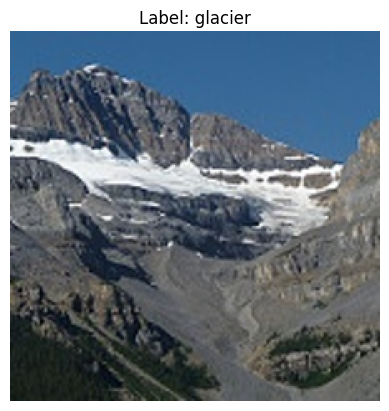

In [31]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

## **7. Create model**

#### **Training and Evaluation Functions for Model**

In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct, total = 0, 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Calculate predictions
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # Calculate average loss and accuracy
    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [18]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            batch_train_losses.append(loss.item())

            _, preds = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        # Calculate average training loss for the epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs}:\t"
            f"Train Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\t"
            f"Val Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

#### **DenseNet Model Implementation**

![](Structure-of-the-DenseNet.png)

In [19]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)

        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [20]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Initialize DenseBlocks
        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(
                DenseBlock(num_layers, in_channels, growth_rate)
            )
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(
                    nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                    )
                )
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## **8. Training**

In [21]:
n_classes = len(list(classes.keys()))
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [22]:
device

'cuda'

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=20
)

Epoch 1/20:	Train Loss: 1.4856	Train Acc: 0.4443	Val Loss: 1.2988	Val Acc: 0.5142
Epoch 2/20:	Train Loss: 1.2483	Train Acc: 0.5436	Val Loss: 1.1741	Val Acc: 0.5606
Epoch 3/20:	Train Loss: 1.1652	Train Acc: 0.5708	Val Loss: 1.1195	Val Acc: 0.5824
Epoch 4/20:	Train Loss: 1.1157	Train Acc: 0.5827	Val Loss: 1.0657	Val Acc: 0.6002
Epoch 5/20:	Train Loss: 1.0679	Train Acc: 0.6086	Val Loss: 1.0118	Val Acc: 0.6322
Epoch 6/20:	Train Loss: 1.0257	Train Acc: 0.6202	Val Loss: 0.9752	Val Acc: 0.6402
Epoch 7/20:	Train Loss: 0.9850	Train Acc: 0.6399	Val Loss: 0.9399	Val Acc: 0.6558
Epoch 8/20:	Train Loss: 0.9526	Train Acc: 0.6507	Val Loss: 0.9034	Val Acc: 0.6683
Epoch 9/20:	Train Loss: 0.9118	Train Acc: 0.6715	Val Loss: 0.8825	Val Acc: 0.6763
Epoch 10/20:	Train Loss: 0.8782	Train Acc: 0.6832	Val Loss: 0.8402	Val Acc: 0.6892
Epoch 11/20:	Train Loss: 0.8488	Train Acc: 0.6985	Val Loss: 0.8121	Val Acc: 0.7057
Epoch 12/20:	Train Loss: 0.8148	Train Acc: 0.7116	Val Loss: 0.7999	Val Acc: 0.7137
Epoch 13/20:	

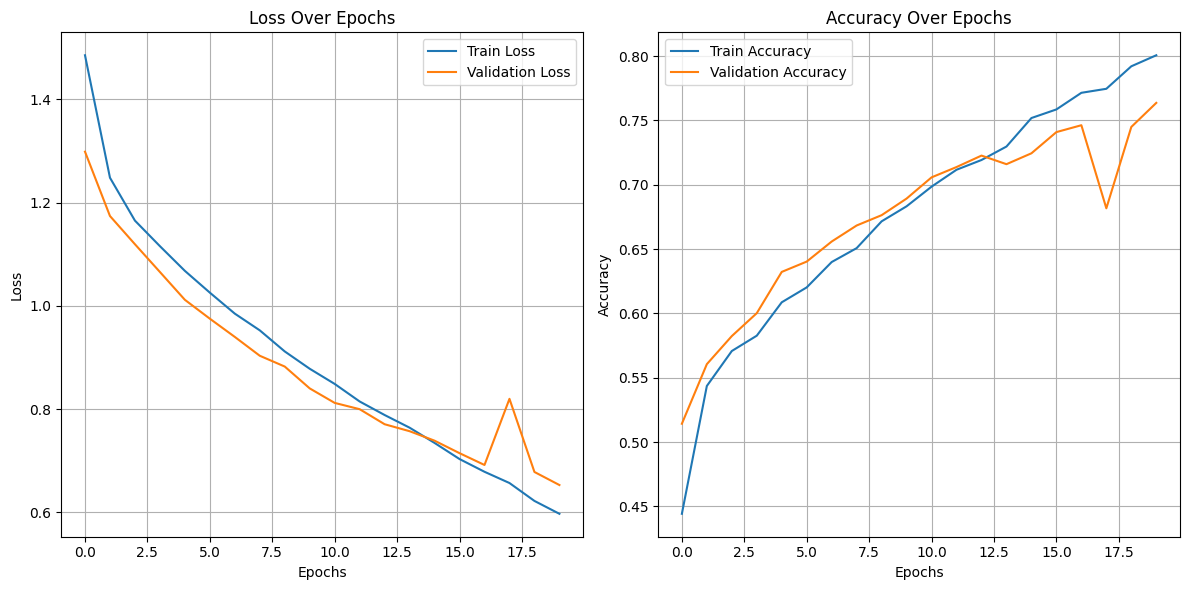

In [24]:
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## **9. Evaluation**

In [25]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset:")
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Evaluation on val/test dataset:
Validation accuracy:  0.763579697239537
Test accuracy:  0.7646666666666667
